In [3]:
# svm(上)--简单使用
from sklearn import svm

# feature vectors
X = [[2,0],[1,1],[2,3]]
# class label
y = [0,0,1]
# 使用svm的SVC方程,线性核函数
clf = svm.SVC(kernel='linear')
clf.fit(X,y)

print(clf)
# 打印支持向量
print(clf.support_vectors_)
# 打印支持向量在特征向量中的下标
print(clf.support_)
# 打印支持向量在每个分类中的个数
print(clf.n_support_)
# 预测分类
print(clf.predict([[2,0]]))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
[[1. 1.]
 [2. 3.]]
[1 2]
[1 1]
[0]


w: [0.90230696 0.64821811]
a: -1.391980476255765
clf.support_vectors_: [[-1.02126202  0.2408932 ]
 [-0.46722079 -0.53064123]
 [ 0.95144703  0.57998206]]
clf.coef_: [[0.90230696 0.64821811]]


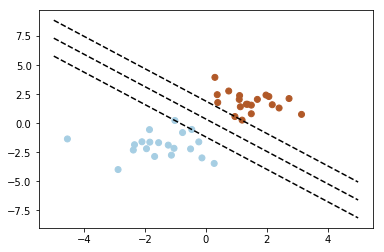

In [5]:
# svm(上)--画图展示
import numpy as np
import pylab as pl
from sklearn import svm

# 创建40个具有正态分布的随机点
np.random.seed(0)
X = np.r_[np.random.randn(20,2) - [2,2],np.random.randn(20,2) + [2,2]]
Y = [0] * 20 + [1] * 20

# model
clf = svm.SVC(kernel='linear')
clf.fit(X,Y)

# 得到超平面,计算斜率和截距
# 方程：w0*x+w1*y+w3=0 点斜式：y=-(w0/w1)*x+(w3/w1)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5,5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# 得到支持向量的两条切线
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

print('w:',w)
print('a:',a)
print('clf.support_vectors_:',clf.support_vectors_)
print('clf.coef_:',clf.coef_)

# 画图
pl.plot(xx,yy,'k--')
pl.plot(xx,yy_down,'k--')
pl.plot(xx,yy_up,'k--')

pl.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],s=80,facecolors='none')
pl.scatter(X[:,0],X[:,1],c=Y,cmap=pl.cm.Paired)

pl.axis('tight')
pl.show()

In [ ]:
# svm(下)--人脸识别案例
from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt

# 交叉验证库
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
# 调试参数函数
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# 主成分分析PCA库
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 日志打印
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(message)s')

# 下载人脸数据集
lfw_people = fetch_lfw_people(min_faces_per_person=70,resize=0.4)

# n个实例的宽高
n_samples,h,w = lfw_people.images.shape

# 得到人脸特征向量的矩阵，并计算维度
X = lfw_people.data
n_features = X.shape[1]

# 得到人脸的class labal，并计算有多少个分类即人脸
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('Totle dataset size:')
print('n_samples: %d' % n_samples)
print('n_features: %d' % n_features)
print('n_classes: %d' % n_classes)

# 拆分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

# 降维，减少特征值，增加准确性
n_components = 150

print('Extracting the top %d eigenfaces from %d faces' % (n_components,X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components,whiten=True).fit(X_train)
print('done in %0.3fs' % (time() - t0))

eigenfaces = pca.components_.reshape((n_components,h,w))

print('Projecting the input data on the eigenfaces orthonormal basis')
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done in %0.3fs' % (time() - t0))

# 训练svm分类器
print('Fitting the classifier to the training set')
t0 = time()
param_grid = {'C':[1e3,5e3,1e4,5e4,1e5],'gamma':[0.0001,0.0005,0.001,0.005,0.01,0.1],}
clf = GridSearchCV(SVC(kernel='rbf',class_weight='auto'),param_grid)
clf = clf.fit(X_train_pca,y_train)
print('done in %0.3fs' % (time() - t0))

print('Best estimator found by grid search:')
print(clf.best_estimator_)

# 预测，输出准确率，在对角线上越多准确率越高
print('Predicting peoples names on the test set')
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs' % (time() - t0))

print(classification_report(y_test,y_pred,target_names=target_names))
print(confusion_matrix(y_test,y_pred,labels=range(n_classes)))

# 画图，可视化展示
def plot_gallery(images,titles,h,w,n_row=3,n_col=4):
    plt.figure(figsize=(1.8 * n_col,2.4 * n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row,n_col,i + 1)
        plt.imshow(images[i].reshape((h,w)),cmap=plt.cm.gray)
        plt.title(titles[i],size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred,y_test,target_names,i):
    pred_name = target_names[y_pred[i]].rsplit(' ',1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ',1)[-1]
    return 'predicted: %s \ntrue: %s' % (pred_name,true_name)

prediction_titles = [title(y_pred,y_test,target_names,i) for i in range(y_pred.shape[0])]
plot_gallery(X_test,prediction_titles,h,w)
eigenfaces_titles = ['eigenface %d' % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces,eigenfaces_titles,h,w)

plot.show()

2019-04-30 20:40:12,501 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-04-30 20:40:16,156 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-04-30 20:40:21,466 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-04-30 20:40:31,309 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015
